In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
import pandas as pd
import gpflow_tools.mean_func as mf
from random import sample
import gpflow_tools.kernels as kern
import validation.metrics as metrics
from sklearn.model_selection import KFold

In [14]:
data = pd.read_excel('Data/full_data_10_08.xlsx')
cols = ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
for c in data.columns:
    if 'afp' in c or 'bfp' in c or 'mpf' in c or 'efp' in c:
        cols.append(c)

In [15]:
for i in data.index:
    if data.loc[i, 'Shear_Rate'] == 0:
        data = data.drop([i])
        #data.loc[i, 'Shear_Rate'] = 1e-4 

for c in ['Mw', 'Melt_Viscosity', 'Shear_Rate']:
    data[c] = np.log10(data[c])

In [16]:
filtered_data = data.loc[:, cols].dropna()
X_tot = np.array(filtered_data.drop(columns=['Melt_Viscosity']))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

-0.0007658577651455655


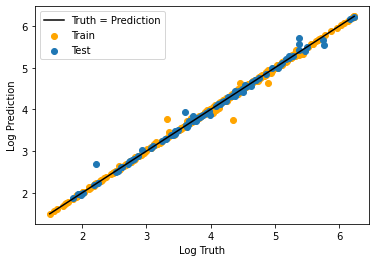

0.0011682472924208812


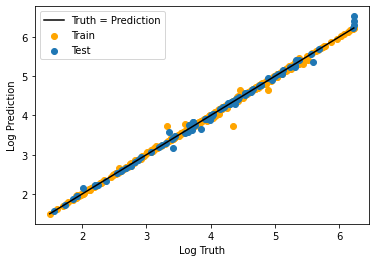

0.0014559461718778202


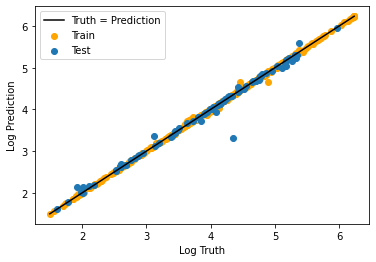

0.001322683992882537


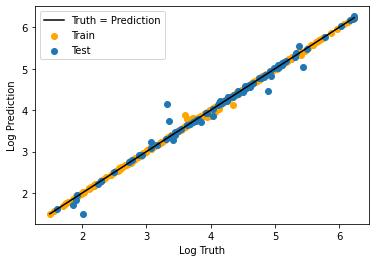

In [19]:
#A = np.concatenate((np.array([3.4]), np.zeros(X_tot.shape[1] - 1))).reshape(-1,1)
#mf = gpflow.mean_functions.Linear(A = A, b = np.zeros((1)))
accuracy = []
models = []
mean_mol = mf.mol_weight_mean(X_tot.shape[1])
mean_temp = mf.temp_mean()
mean = mf.weight_temp_mean(input_dim = X_tot.shape[1])
mean_s = mf.shear_mean(input_dim = X_tot.shape[1])
mean_sw = mf.weight_shear_mean(input_dim = X_tot.shape[1])
mean_funcs = [None, mean_mol, mean_s, mean_sw]
i =0
kf = KFold(n_splits=5, shuffle = True)
for means in mean_funcs:
    for train_index, test_index in kf.split(X_tot):
        X, xx = X_tot[train_index], X_tot[test_index]
        Y, yy = Y_tot[train_index], Y_tot[test_index]
        k = gpflow.kernels.Matern52()
        models.append(gpflow.models.GPR(data=(X, Y), kernel=k, mean_function= means))
        m = models[-1]
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
        mean, var = m.predict_y(xx)
        accuracy.append(metrics.OME(mean, yy))
        mean_train, var_train = m.predict_y(X)
        if i == 4:
            print(np.mean(accuracy))
            plt.scatter(Y, mean_train, c = 'orange')
            plt.scatter(yy, mean)
            plt.plot(np.linspace((min(Y)[0]), (max(Y)[0]), num = 2),np.linspace((min(Y)[0]), (max(Y)[0]), num = 2),'k-')
            plt.ylabel('Log Prediction')
            plt.xlabel('Log Truth')
            plt.legend(['Truth = Prediction','Train','Test'])
            plt.show()
        i += 1
    accuracy = []
    i = 0


0.9169343182705341
3.390254941291775


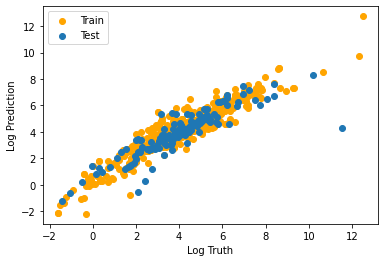

In [23]:
## predict mean and variance of latent GP at test points
mean, var = m.predict_y(xx)
## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)



# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
mean_train, var_train = m.predict_y(X)
plt.scatter(Y, mean_train, c = 'orange')
plt.scatter(yy, mean)
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Train','Test'])
rmse = metrics.RMSE(mean, yy)
mape = metrics.MAPE(mean, yy)
print(rmse)
print(mape)

In [11]:
X_tot[0]

array([ 5.43883653e+00,  2.00000000e+02, -1.36521739e+00,  0.00000000e+00,
        0.00000000e+00,  3.75000000e-01,  1.25000000e-01,  6.25000000e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.25000000e-01,  6.25000000e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.25000000e-01,  0.00000000e+00,  3.75000000e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.25000000e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.87500000e-01,  

In [42]:
filtered_data

,Mw,Temperature,Shear_Rate,Melt_Viscosity,afp_C2_C4_C4,afp_C2_C4_H1,afp_C3_C3_C3,afp_C3_C3_C4,afp_C3_C3_H1,afp_C3_C3_O1,...,efp_fam_ketone,efp_fam_polyamides,efp_fam_single,efp_main_chain_rel,efp_main_chain_ring,efp_norm_mol_wt,efp_numatoms_none_H,efp_ring,efp_ring_dist_shortest,efp_side_chain_abs
187,5.438837,200.0,-1.365217,3.159468,0.0,0.0,0.375,0.125,0.625,0.0,...,0.0,0.0,0.0,0.125,0.0,0.542458,0.5,0.75,0.2,0.666667
188,5.438837,200.0,-0.956522,3.142857,0.0,0.0,0.375,0.125,0.625,0.0,...,0.0,0.0,0.0,0.125,0.0,0.542458,0.5,0.75,0.2,0.666667
189,5.438837,200.0,-0.565217,3.116279,0.0,0.0,0.375,0.125,0.625,0.0,...,0.0,0.0,0.0,0.125,0.0,0.542458,0.5,0.75,0.2,0.666667
190,5.438837,200.0,-0.147826,3.069767,0.0,0.0,0.375,0.125,0.625,0.0,...,0.0,0.0,0.0,0.125,0.0,0.542458,0.5,0.75,0.2,0.666667
191,5.438837,200.0,0.243478,3.006645,0.0,0.0,0.375,0.125,0.625,0.0,...,0.0,0.0,0.0,0.125,0.0,0.542458,0.5,0.75,0.2,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,4.762679,160.0,2.643504,3.239852,0.0,0.0,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.00,0.0,0.000000
898,4.762679,160.0,2.963406,3.077491,0.0,0.0,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.00,0.0,0.000000
899,4.762679,160.0,3.298960,2.889299,0.0,0.0,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.00,0.0,0.000000
900,4.762679,160.0,3.696938,2.667897,0.0,0.0,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.00,0.0,0.000000


In [15]:
l[:, 0:]

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

gpflow_tools.mean_func.weight_temp_mean

In [31]:
max(Y)

array([6.22911051])